<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Scope-of-the-Study" data-toc-modified-id="Scope-of-the-Study-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Scope of the Study</a></span></li><li><span><a href="#Cleaning-the-Data" data-toc-modified-id="Cleaning-the-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cleaning the Data</a></span></li><li><span><a href="#Exploratory-Data-Analysis-of-the-Mayoral-Race" data-toc-modified-id="Exploratory-Data-Analysis-of-the-Mayoral-Race-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Data Analysis of the Mayoral Race</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#NCR" data-toc-modified-id="NCR-3.0.0.1"><span class="toc-item-num">3.0.0.1&nbsp;&nbsp;</span>NCR</a></span></li><li><span><a href="#Laguna-(Region-4A)" data-toc-modified-id="Laguna-(Region-4A)-3.0.0.2"><span class="toc-item-num">3.0.0.2&nbsp;&nbsp;</span>Laguna (Region 4A)</a></span></li><li><span><a href="#Nueva-Ecija-(Region-3)" data-toc-modified-id="Nueva-Ecija-(Region-3)-3.0.0.3"><span class="toc-item-num">3.0.0.3&nbsp;&nbsp;</span>Nueva Ecija (Region 3)</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Municipalities-with-no-competition" data-toc-modified-id="Municipalities-with-no-competition-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Municipalities with no competition</a></span></li><li><span><a href="#Why-your-vote-matters" data-toc-modified-id="Why-your-vote-matters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Why your vote matters</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

# Insights on the Recent Elections

The recently-concluded elections in the Philippines saw an overwhelming win for the candidates in the administration slate, in spite of questionable morals and credentials of the candidates. Many were quick to accuse the voters of being uninformed in their decisions.

However, the local elections paint a different picture. We've seen political clans fall in Pasig (where Vico Sotto won over Bobby Eusebio) and in Manila (Isko Moreno winning the mayoral election against Erap Estrada). So maybe, the "uninformed voter" concept is a myth. Perhaps people are more invested in the local elections because their policies directly their lives.

We look at the results of the local elections, with data scraped from the Comelec website (https://2019electionresults.comelec.gov.ph/#/dashboard). We would like to thank Dr. Christian Alis and the ACCeSs@AIM laboratory for giving us access to the data so that we could play around with it.

### Scope of the Study
First, we do some housekeeping. In the next cell, we import the libraries that will be used in our python implementation.

In [1]:
import os
import os.path
import glob
import json
import re
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas

We chose to focus our attention to the top 3 most populated regions in the country, due to time constraints. We first looked at the 2015 census data for the entire Philippines, to determine which three regions have the highest population.

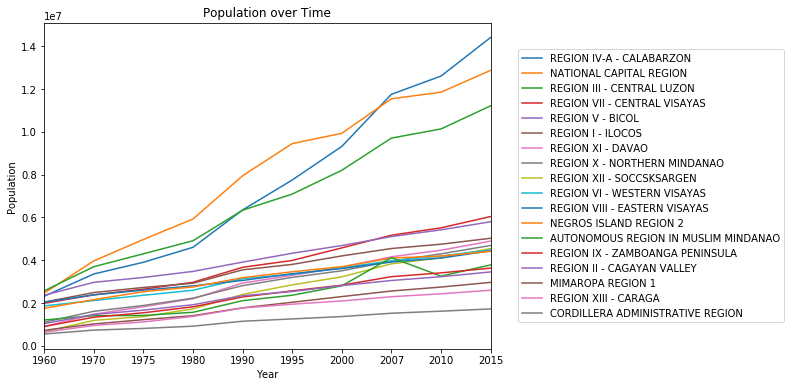

In [2]:
def clean_yr(date):
    """
    Cleans the year column in the census data
    """
    form = re.compile(r'(\d+)\n\w+')
    
    if form.match(date):
        return form.findall(date)[0]
    else:
        return np.nan

def pop_ot(df):
    """
    Plots of population vs time
    """
    df = df.sort_values('2015',axis=1, ascending=False)
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(8, 6)

    for col in list(df.columns):
        df[col].plot(ax=ax, legend=True)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05,0.5))
    ax.set_xlabel('Year');
    ax.set_ylabel('Population');
    ax.set_title('Population over Time');
    
    plt.close()

    return fig

file = '/mnt/data/public/census/_PHILIPPINES_Statistical Tables.xls'

# Wrangling dataframe
df = pd.read_excel(file, header=3).T.reset_index()
df['index'] = df['index'].apply(lambda x: clean_yr(x))
df = df.fillna('None')
df = df.drop(labels=[0,1,3,24,25,26,27,28,29,30,31,32,33,22,23], axis=1)
df.iloc[0]['index'] = 'Year'
df.columns = df.iloc[0]
df = df.drop(0)
df = df[df['Year']!='None'].set_index('Year') # df used for computation
df = df.sort_values('2015',axis=1, ascending=False)
df_ph = df.drop(labels='PHILIPPINES', axis=1) # df that will be plotted

del df_ph.index.name
del df_ph.columns.name
# display(df_ph)
display(pop_ot(df_ph))

Based on the census data from 2015, the three most populated regions include the NCR, Region IV-A and Region III. In the cell below, we determine how much of the Philippine population came from these three regions.

In [3]:
total = 0
for col in df.columns[1:4]:
    print(f'Population of {col}: {df[col].sum()}')
    total += df[col].sum()
perc = 100*total/df['PHILIPPINES'].sum()
print(f'\nThe top 3 most populated regions ' 
      f'contribute to {round(perc,2)}% of the total population!')

Population of REGION IV-A - CALABARZON: 76382726.0
Population of NATIONAL CAPITAL REGION: 80941252.0
Population of REGION III - CENTRAL LUZON: 68174909.0

The top 3 most populated regions contribute to 35.14% of the total population!


### Cleaning the Data

First, we define the functions that will be used to gather and transform data.

In [4]:
def save_list_txt(list_obj, filename):
    '''Saves list into a text file. 1 Entry = 1 New Line

    Input: 
        list_obj: list to save
        filename: of .txt file. No need for .txt extenstion
    '''

    with open(filename+'.txt', 'w') as f:
        for item in list_obj:
            f.write(f"{item}\n")


def access_res(direc):
    '''Creates a list of files to access from the given directory.

    Input:
        direc: regional directories to access
    Returns:
        access_list: list of files to access
    '''

    # Creates list of files to be accessed in results direc
    access_list = []
    json_filt = re.compile(r'\d+.json')
    for root, dirs, files in os.walk(direc, topdown=False):
        for file in files:
            if json_filt.match(file):
                access_list.append(root+'/'+file)
    return access_list


def gen_candi(position):
    '''Creates a list of candidate data from contests. LOCAL ELECTIONS ONLY!

    Input:
        position: string
            position of interest in all caps
    Returns:
        3 element tuple:
            cc_list: list of position code names
            cc_pos: list of dictionaries cc code:position title
            cc_names: list of dictionaries boc code: candidate name

    '''

    # Create list of json files to be filtered
    elec_files = [f for f in os.listdir(
        '/mnt/data/public/elections/nle2019/contests')
        if re.match(r'\d+.json', f)]

    cc_list = []  # list of cc numbers
    cc_pos = []  # list of dict, translates cc num to position
    candi_names = []
    for file in elec_files:
        with open('/mnt/data/public/elections/nle2019/contests/'+file) as f:
            temp = json.load(f)

        if re.match(position, temp['ccn']):
            cc_list.append(temp['cc'])
            cc_pos.append({temp['cc']: temp['cn']})
            candi_names += [item for item in temp['bos']]

    return (cc_list, cc_pos, candi_names)


def pos_reg(reg, cc):
    '''Returns a list of dictionaries of candidates for given position.

    Input:
        reg: list of files to access per given region
        cc: code list for selected position
    Return:
        candi_list: list of dictionaires
            list of candidates for a given position (specified by cc)
            in a region
    '''
    candi_list = []
    for file in reg:
        with open(file, 'r') as f:
            temp_dat = json.load(f)
        for candi in temp_dat['rs']:
            if candi['cc'] in cc:
                # list of dictionaries
                # dictionaries with the same cc are running in the same muni
                candi_list.append(candi)
    return candi_list

def clean_city(x):
    '''Cleans the location column so that the municipality names match the
    names listed in the geopandas dataframe.
    '''
    temp = x.split('-')
    region = temp[0].replace('MAYOR','').strip()
    city = temp[1].replace('CITY','')
    city = city.replace('OF','')
    city = city.replace('GEN.','GENERAL')
    city = city.replace('JALA','JALA-JALA')
    city = city.replace('SCIENCE','')
    city = city.strip()
    city_new = city.split('(')
    
    return region.lower() +':'+ city_new[0].strip().lower()

def party_class(df):
    '''Groups the parties according to their affiliation to party of the
    currrent administration.
    
    Input: Dataframe
    
    Output: Dataframe with grouping column.
    '''

    allies = ['NACIONALISTA PARTY',
              "NATIONALIST PEOPLE'S COALITION",
              'LAKAS CHRISTIAN  MUSLIM DEMOCRATS',
              'NATIONAL UNITY PARTY',
              'PROBINSYA MUNA DEVELOPMENT INITIATIVE'
              'CENTRIST DEMOCRATIC PARTY',
              'ANG KAPATIRAN',
              'BANGON PILIPINAS',
              'UNITED BANGSAMORO JUSTICE PARTY']
    
    # Initialization of empty list
    pol_grip = []
    
    # Create dataframe that groups parties
    for idx, row in df.iterrows():
        if row['Party'] == 'PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN':
            pol_grip.append({idx:2})
        elif row['Party'] in allies:
            pol_grip.append({idx:1})
        else:
            pol_grip.append({idx:0})
    
    # Format dataframe in prep for merge!
    df_temp = pd.DataFrame(pol_grip).stack()
    df_temp.name = 'Party Color'
    df_temp = df_temp.reset_index(level=0, drop=True)
    df = df.join(df_temp)
    
    return df

def grp_df(ct_map, cn_map,  candi):
    '''Concatenates name dataframe, position dataframe and votes dataframe.
    According to cc code. Performs groupby on the party and computations and
    gets the percentage of votes for each party per municipal.
    
    Input:
        ct_map: list of dictionaries
            maps cc number to title
        cn_map: list of dictionaries
            maps boc number to candidate name
        candi: list of dictionaries
            all candidates for the position for a region
    Returns:
        df_candi: pandas dataframe
            grouped by candidates, party per municipal
        df_party: pandas dataframe
            grouped by parties per municipal
    '''
    
    df_names = pd.DataFrame(cn_map)
    df_names = df_names[['boc', 'bon', 'pn']]

#     Dataframe where cc are index labels and value is in the form:
#     position - region - municipality

    df_title = pd.DataFrame(ct_map)
    df_title = df_title.stack()
    df_title = df_title.reset_index(level=0, drop=True)
    df_title.name = 'Location'

    # Creating a general dataframe:
    df = pd.DataFrame(candi)
    df = df.join(df_title, on='cc', how='inner')
    df = df.join(df_names.set_index('boc'), on='bo', how='inner')
    df = df.drop(columns=['bo', 'cc', 'per', 'ser'])
    df.columns = ['Total Voters', 'Votes', 'Location', 'Candidate', 'Party']
    df['Location'] = df['Location'].apply(lambda x: clean_city(x))

    # Groupby operations to compute the percentages
    df_candi = df.groupby(['Location',
                           'Party', 'Candidate'])['Votes',
                                                  'Total Voters'].sum()
    df_candi['Percentage'] = 100*df_candi['Votes']/df_candi['Total Voters']
    df_candi = df_candi.reset_index()
    df_candi['Province'] = df_candi['Location'].apply(lambda x: 
                                                      x.split(':')[0])
    df_candi = df_candi.set_index(['Location', 'Party'])

    df_party = df_candi.reset_index()
    df_party = df_party.groupby(['Location', 'Party'])['Votes',
                                                       'Percentage'].sum()
    df_party['Total Voters'] = 100*df_party['Votes']/(df_party['Percentage'])
    df_party = df_party.reset_index()
    df_party['Province'] = df_party['Location'].apply(lambda x:
                                                      x.split(':')[0])
    df_party = df_party.set_index(['Location', 'Party'])
#     df_party = party_class(df_party)

    return (df_candi, df_party)

def top_count(df_p, df_c):
    '''
    Returns the winning candidate's party per municipal, returns the details
    on the number of candidates per region.
    '''
    df_p = df_p.reset_index()
    df_p = df_p.groupby(['Location'])['Party', 'Votes',
                                      'Percentage', 'Province'].max()
    df_p = df_p.sort_values('Percentage', ascending=False)
    df_p = party_class(df_p)

    df_c = df_c.reset_index()
    df_c = df_c.groupby(['Location','Province'])['Candidate'].nunique()
    df_c = df_c.sort_values()
    df_c = df_c.reset_index()
    df_c = df_c.set_index('Location')

    return (df_p, df_c)

def format_gdf(ph_muni):
    '''Formats the municipalities of the geopandas dataframe.'''
    
    ph_muni['coords'] = ph_muni[
        'geometry'].apply(lambda x: x.representative_point().coords[:])
    ph_muni['coords'] = [coords[0] for coords in ph_muni['coords']]
    ph_muni.loc[960]['NAME_2'] = 'caloocan'
    ph_muni['NAME_2'] = ph_muni['NAME_2'].apply(lambda x: x.replace('Ã±','ñ'))
    ph_muni['NAME_1'] = ph_muni[
        'NAME_1'].apply(lambda x: x.replace('Metropolitan Manila',
                                            'ncr').lower())
    ph_muni['NAME_2'] = ph_muni[
        'NAME_2'].apply(lambda x: x.lower().replace('city',
                                                    '').replace('of',
                                                                '').strip())
    ph_muni['Location'] = ph_muni['NAME_1'] +':'+ ph_muni['NAME_2']
    
    return ph_muni

def geomap(ph_muni, df, prov, colors=5):
    '''Plots the municipalities according to the attributes:
        * % of votes for the winning candidate
        * classification if they're with / allied with the current 
        administration
    '''

    ph_prov = ph_muni[ph_muni['NAME_1']==prov.lower()]
    merged = ph_prov.merge(df, left_on='Location', right_on='Location')

    # Initialization
    cmap = 'GnBu'
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(20, 20)
    
    # Plotting based on percentage
    merged.plot(column='Percentage', cmap=cmap, ax=ax[0],
                              scheme='equal_interval', k=colors, legend=True,
               vmax=10)

    for idx, row in merged.iterrows():
        ax[0].annotate(s=row['NAME_2'], xy=row['coords'],
                     horizontalalignment='center')
    ax[0].set_title(label=prov+': Winning Candidate Support (%)'
                    ' per Municipality');

    # Plot Party Allegiance
    cmap = 'OrRd'
    merged.plot(column='Party Color', cmap=cmap, ax=ax[1], 
                scheme='equal_interval', k=3, legend=True, vmax=3)

    for idx, row in merged.iterrows():
        ax[1].annotate(s=row['NAME_2'], xy=row['coords'], 
                       horizontalalignment='center')
    ax[1].set_title(label=prov+': Allegiance to Current Admin');
    
    plt.close()

    return fig

def geomap_contest(ph_muni, df, prov):
    '''Plots which municipalities have contested and non-contested elections.
    '''
    ph_prov = ph_muni[ph_muni['NAME_1']==prov.lower()]
    merged = ph_prov.merge(df, left_on='Location', right_on='Location')

    # Plotting based on percentage
    cmap = 'coolwarm'
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20, 20)
    
    colors = merged['Contest'].nunique()
    
    # Some regions may not need 3 colors.
    if colors == 3:
        vmx = 2.5
        vmn = -0.5
    elif colors == 2:
        vmx = 2.5
        vmn = -2.5
    else:
        vmx = 2.5
        vmn = 0

    merged.plot(column='Contest', cmap=cmap, ax=ax,
                              scheme='equal_interval', k=colors, legend=True,
               vmin=vmn, vmax=vmx)

    for idx, row in merged.iterrows():
        ax.annotate(s=row['NAME_2'], xy=row['coords'],
                     horizontalalignment='center')
    ax.set_title(label=prov+': Contested vs No Contest Elections');
    
    plt.close()
    
    return fig

def chk_contest(x):
    '''Checks if there is contest between 2 party groups per municipality.
    '''
    prod = np.prod(x) # uncontested red
    suma = np.sum(x) # uncontested blue
    
    if not np.logical_xor(prod, suma):
        if prod:
            return 2
        else:
            return -2
    else:
        return 0

def cnt_plot(df, prov):
    '''Plots the number of candidates per municipality
    '''
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(6,8)
    df = df[df['Province']==prov.lower()]
    df.plot(kind='barh', color='Orange', ax=ax, legend=False)
    ax.set_title(prov+': Number of Candidates per Muni');

    plt.close()
    return fig

Now, we create the visualization. First, we look at geopandas data (downloaded from https://gadm.org/index.html).

In [5]:
ph_muni = geopandas.GeoDataFrame.from_file("./geo_pd/gadm36_PHL_2.shp")
ph_muni = format_gdf(ph_muni)

We now create a list of files to access the election results from the top 3 most populated regions, namely NCR, Region IV-A, and Region III. The data can befound in the directories listed below.

Note that within each directory the relevant files may not necessarily be on the same level. Some are found in heavily nested directories while others are near the top level. The `access_res` function uses os.walk function to search for json files that have numerical filenames.

The json files in these directories contain all the election results from Senatorial to Councilor positions. It also contains other metadatas such as ballot statistics (over votes, under votes etc.). For our case we are only interested in the local elections, specifically Mayoral elections.

In [6]:
# Create list of files to access
ncr = access_res('/mnt/data/public/elections/nle2019/results/NCR')
reg4a = access_res('/mnt/data/public/elections/nle2019/results/REGION IV-A')
reg3 = access_res('/mnt/data/public/elections/nle2019/results/REGION III')

We now retrieve all relevant data for the mayoral elections: `gen_cardi` function access the contests directory and retrieves the data from the json files with the specified position; in this case 'MAYOR'.

The candidate json files can be mapped as follows:

* ccn: position
* cc: position code
* cn: position name (includes location)
* bos: candidate names

We will need to map out the cc (position code) to its corresponding cn (given by `pos_title`)  and bos (given by `pos_name`). We will also need to list down the position codes (given by `cc`) so that we can map it to the necessary data in the results directories stated above.

In [7]:
position = 'MAYOR'
cc, pos_title, pos_name = gen_candi(position)

# pos_title, pos_name Dictionary of dictionaries
# 1 dict = 1 municipality
# position code : candidates
# cc = code list for selected position

We extract a list of candidates per region in the cell below. Using the lists we generated from `access_res` we now access each json file using the `pos_reg` function.

Mapped to the rs key are a dictionary of cc codes mapped to the list of candidates for a specific position. This is where the `cc list` comes in to play, `pos_reg` checks if the cc code is in the list of cc codes that we want to access.

The output is a list of dictionaries for each selected region.

In [8]:
# Access each file and collect needed data
# WARNING: Running this cell takes some time
ncr_candi = pos_reg(ncr, cc)
reg4a_candi = pos_reg(reg4a, cc)
reg3_candi = pos_reg(reg3, cc)

We now save the data on the candidates for backup.

In [11]:
# Save data in text file
save_list_txt(ncr, 'ncr_files')
save_list_txt(ncr_candi, 'ncr_candidates')
save_list_txt(reg4a, 'reg4a')
save_list_txt(reg4a_candi, 'reg4a_candidates')
save_list_txt(reg3, 'reg3')
save_list_txt(reg3_candi, 'reg3_candidates')

We are interested in the general data in each region. In particular, we look at the number of candidates and the party of the winning candidate per municipality. We do some more data cleaning in the cell below.

`grp_df` creates 2 dataframes:
* All 'MAYOR' candidates per municipality in the specified region.
* The first dataframe grouped by parties.

It does this by mapping out `pos_title` and `pos_name` which are both list of dictionaries to the list of candidates per region.

`top_count` returns 2 dataframes:
* A dataframe with only the winning parties per municipality.
* The count of running candidates per municipality.

In [12]:
# Get Dataframe per of each candidate and each party per municipality
df_ncr_c, df_ncr_p = grp_df(pos_title, pos_name, ncr_candi)
df_reg4a_c, df_reg4a_p = grp_df(pos_title, pos_name, reg4a_candi)
df_reg3_c, df_reg3_p = grp_df(pos_title, pos_name, reg3_candi)

#df_top = dataframe of top parties per Municipal
df_ncr_topp, df_ncr_cnt = top_count(df_ncr_p, df_ncr_c)
df_reg4a_topp, df_reg4a_cnt = top_count(df_reg4a_p, df_reg4a_c)
df_reg3_topp, df_reg3_cnt = top_count(df_reg3_p, df_reg3_c)

For example, we are interested in the political parties competing for the mayoral position for each city/municipality in NCR. We display the parties and the votes that they got in the DataFrame below.

For data on Region III and Region IV-A, we can just uncomment the corresponding line and run the cell below.

In [13]:
display(df_ncr_p)
#display(df_reg3_p)
#display(df_reg4a_p)

Votes  \
Location        Party                                                 
ncr:caloocan    INDEPENDENT                                   11543   
                NACIONALISTA PARTY                           430137   
                WORKERS AND PEASANTS PARTY                     3132   
ncr:las piñas   INDEPENDENT                                   23735   
                NATIONALIST PEOPLE'S COALITION               170972   
ncr:makati      BIGKIS PINOY MOVEMENT                         23721   
                INDEPENDENT                                    4666   
                LGBTQ PARTY                                    1541   
                UNA ANG MAKATI                                98653   
                UNITED NATIONALIST ALLIANCE                  179522   
ncr:malabon     LIBERAL PARTY                                100795   
                NACIONALISTA PARTY                            56156   
ncr:mandaluyong INDEPENDENT                                    8589   
                PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN  128661   
ncr:manila      ASENSO MANILEÑO MOVEMENT                     357925   
                INDEPENDENT                                    3933   
                PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN  138923   
                PEDERALISMO NG DUGONG DAKILANG SAMAHAN         2262   
                PWERSA NG MASANG  PILIPINO                   210605   
ncr:marikina    PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN  158024   
ncr:muntinlupa  LIBERAL PARTY                                164144   
                NATIONAL UNITY PARTY                          52127   
                PEDERALISMO NG DUGONG DAKILANG SAMAHAN          442   
                WORKERS AND PEASANTS PARTY                     1065   
ncr:navotas     PARTIDO FEDERAL NG PILIPINAS                  33469   
                PARTIDO NAVOTEÑO                              79262   
ncr:parañaque   INDEPENDENT                                    1861   
                LAKAS CHRISTIAN  MUSLIM DEMOCRATS             53101   
                PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN  170118   
ncr:pasay       INDEPENDENT                                    2104   
                LGBTQ PARTY                                   25446   
                NATIONALIST PEOPLE'S COALITION                35784   
                PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN  121391   
                PEDERALISMO NG DUGONG DAKILANG SAMAHAN         5282   
ncr:pasig       AKSYON DEMOKRATIKO                           209370   
                NACIONALISTA PARTY                           121556   
ncr:pateros     NACIONALISTA PARTY                             8775   
                PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN   18370   
ncr:quezon      INDEPENDENT                                    8987   
                KATIPUNAN NG DEMOKRATIKONG PILIPINO(KDP)      19106   
                PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN  366215   
                PEDERALISMO NG DUGONG DAKILANG SAMAHAN          555   
                PHILIPPINE GREEN REPUBLICAN PARTY               828   
                SERBISYO SA BAYAN PARTY                      469480   
                WORKERS AND PEASANTS PARTY                     2810   
ncr:san juan    PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN   35060   
                PWERSA NG MASANG  PILIPINO                    24813   
ncr:taguig      INDEPENDENT                                    1370   
                NACIONALISTA PARTY                           175522   
                PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN  111460   
ncr:valenzuela  INDEPENDENT                                    2284   
                LAKAS CHRISTIAN  MUSLIM DEMOCRATS              6226   
                NATIONALIST PEOPLE'S COALITION               248911   

                                                             Percentage  \
Location        Party                                                     
ncr:ca

### Exploratory Data Analysis of the Mayoral Race

We now summarize the results of the mayoral race from NCR, Region IV-A and Region III into three big DataFrame, sorted as follows:

    (1) winning parties per municipality,
    (2) candidates in the mayoral race, and
    (3) "party color" or the alliance of the political party to the administration. We use the following codes for the party color: 
        * 0 if the political party is not affiliated to the administration,
        * 1 if the party is a political ally of PDP-Laban, and
        * 2 if the party is PDP-Laban

Note that opposition parties do not necessarily belong to one faction. We just classified them as either administration-backed candidates or not.

In [20]:
# Summary Dataframes:

# Summary on Parties:
df_sum = df_ncr_topp.append(df_reg4a_topp)
df_sum = df_sum.append(df_reg3_topp)
df_sum = df_sum.reset_index()

# Summary on Candidates:
df_sum_c = df_ncr_c.append(df_reg4a_c)
df_sum_c = df_sum_c.append(df_reg3_c)
df_sum_c = df_sum_c.reset_index()

# Regroup the parties according if ally or not:
df_pp = df_sum_c.set_index(['Candidate'])
df_pp = party_class(df_pp)
df_pp = df_pp.reset_index()
df_pp = df_pp.set_index('Location')

# Get stats on municipals PDP-Laban and Allies vs Opposition!
# **Municipals where PDP-Laban and Allies are unopposed

df_tempa = df_pp.reset_index()
# display(df_tempa)
df_pres = df_tempa.groupby('Location')['Party Color'].unique()
df_pres = df_pres.reset_index()
df_pres['Prod'] = df_pres['Party Color'].apply(lambda x: np.prod(x))
df_pres['Sum'] = df_pres['Party Color'].apply(lambda x: np.sum(x))
df_pres['Contest'] = df_pres['Party Color'].apply(lambda x: chk_contest(x))

Looking at the overall data across the 13 provinces belonging to our chosen three regions, we want to find out if the political parties of the winning candidates are allied with the administration or not.

,Location,Party,Province
Party Color,,,
0.0,122,13,13
1.0,70,4,13
2.0,97,1,13


Text(0.5, 1.0, 'No. Elected per Party Group')

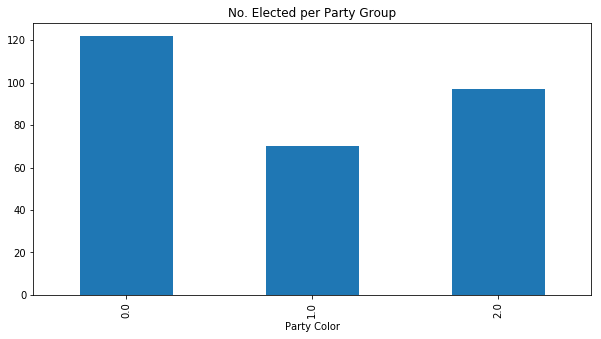

In [21]:
df_res = df_sum.groupby('Party Color').nunique()
display(df_res[['Location', 'Party', 'Province']])

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 5)
df_res['Location'].plot(kind='bar', ax=ax)
ax.set_title('No. Elected per Party Group')

Based on the data from the three chosen regions, there are 13 parties (including independent) across 122 cities/municipalities that are not affiliated with the administration. On the other hand, the parties affiliated with the administration won in 167 cities/municipalities in the region. This is interesting because the administration party is only slightly ahead when looking at the election results in the mayoral race, a far outcry from the results of the senatorial race.

We explored further to try to determine how many municipalities have the administration-affiliated parties running unopposed. We first looked at the frequency distribution of the percent support received by a winning candidate in his city/municipality. We separated the frequency distribution per party color.

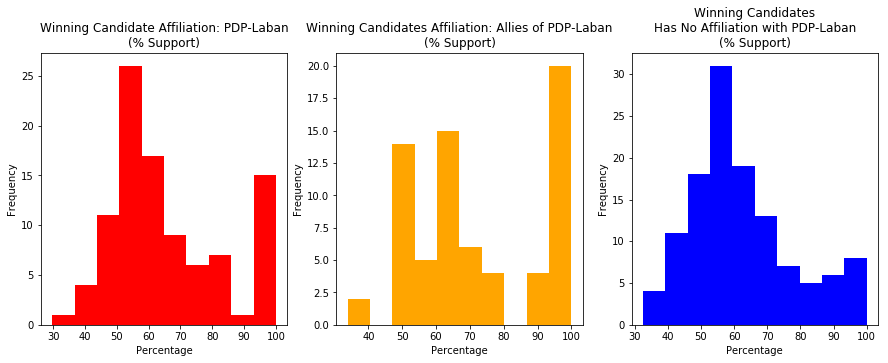

In [22]:
# % support of the WINNING Mayor candidate (Across 3 Most Populated Regions)
# display(df_sum)
fig, ax =  plt.subplots(1,3)
fig.set_size_inches(15, 5)
df_temp = df_sum.set_index('Party Color')
df_pdp_sup = df_temp.loc[2.0]['Percentage']
df_pdp_sup.plot(kind='hist', color='red', ax=ax[0])
ax[0].set_title('Winning Candidate Affiliation: PDP-Laban\n(% Support)');
ax[0].set_xlabel('Percentage');

df_pdp_sup = df_temp.loc[1.0]['Percentage']
df_pdp_sup.plot(kind='hist', color='orange', ax=ax[1])
ax[1].set_title('Winning Candidates Affiliation: Allies of'
                ' PDP-Laban\n(% Support)');
ax[1].set_xlabel('Percentage');

df_pdp_sup = df_temp.loc[0.0]['Percentage']
df_pdp_sup.plot(kind='hist', color='blue', ax=ax[2])
ax[2].set_title('Winning Candidates\nHas No Affiliation with'
                ' PDP-Laban\n(% Support)');
ax[2].set_xlabel('Percentage');

# Around 15 PDP-Laban candidates were completely uncontested
# in their respective municipalities
# Around 20 Allies of PDP-Laban candidates were uncontested 
# in their respective municipalities

# NOTE: Opposition parties do not necessarily belong to one faction
# Opposition party definition: they are parties not 
# affiliated with the party of the current administration

We immediately notice that the PDP-Laban is uncontested in almost 15 areas, while the parties allied with the administration are uncontested in roughly 20 locations.

We now look at the results of the mayoral race per region.

###### NCR

We first look at how many candidates for mayor are present in each city/municipality. In NCR, only the candidate from Marikina ran unopposed.

`cnt_plot` simply plots the amount of mayoral candidates per municipal in the region of interest.

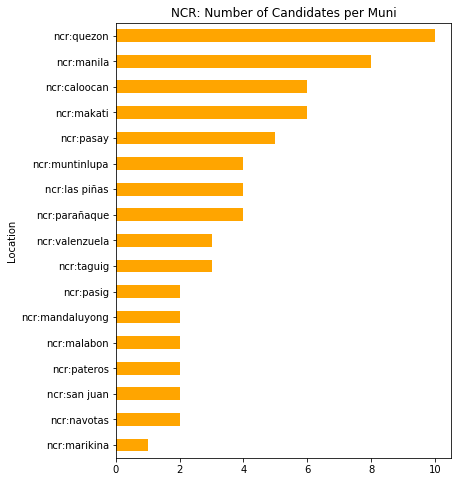

In [23]:
prv_n = 'NCR'
display(cnt_plot(df_ncr_cnt, prv_n))

We now look at the percentage of support the winning mayoral candidate received from his city/municipality. In the left figure, we color-coded the location based on the percent of votes the candidate obtained from his/her locality. We notice that the winning candidate enjoys the strong support of his/her constituency in Caloocan, Valenzuela, Marikina and Mandaluyong.

In the right figure, we determined the political allegiance of the winning candidate. Red means that the candidate ran under the PDP-Laban slate, orange means that the candidate is from a party that is allied with the administration, while the flesh regions refer to the parties that are not affiliated with the administration.

`geomap` function plots the geopandas dataframe merged with the dataframe of interest that contains specific parameters that we want to visualize namely the "chunk" or percentage of votes obtained by the winning candidate and the grouping of the party according to the affiliation with the current admin.

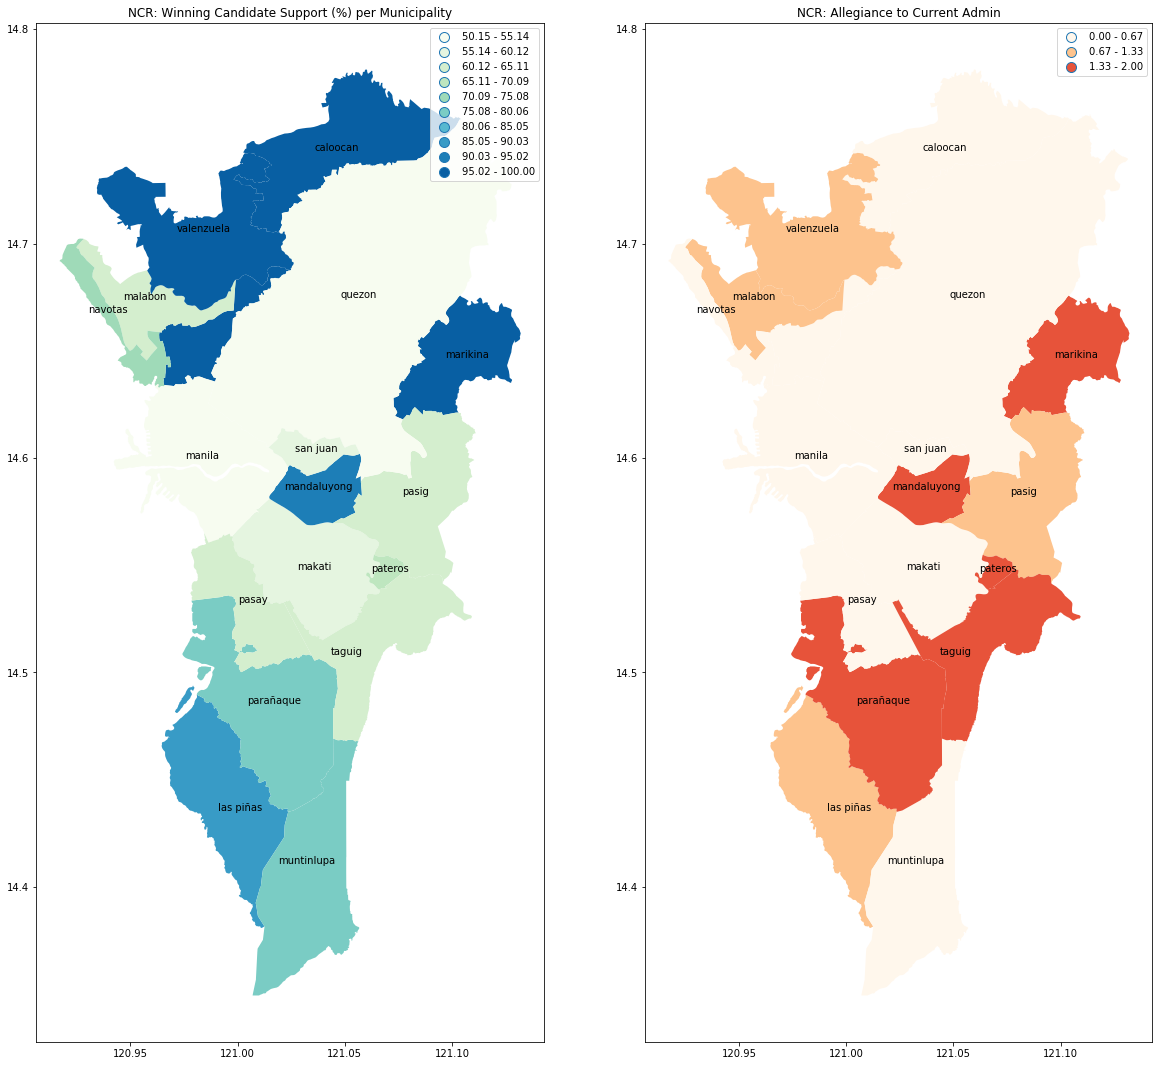

In [24]:
display(geomap(ph_muni, df_ncr_topp, prv_n, 10))

We now try to determine whether the candidates in a particular area are either affiliated with the administration or not. We map it out in the cell below.

* Blue if non-affiliated parties are running uncontested by the PDP affiliated parties.
* Grey if there's competition.
* Red if the PDP affiliated parties are uncontested by non-affiliated.

`geomap_contest` function plots the geopandas dataframe merged with `df_pres` which contains the column that describes the "level" of competition. 

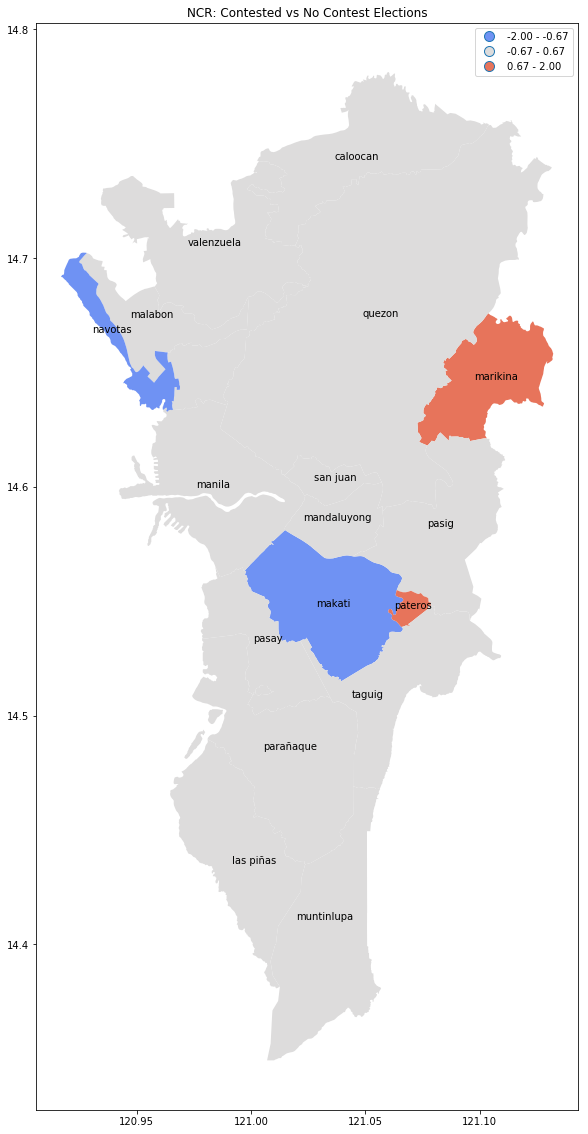

In [29]:
display(geomap_contest(ph_muni, df_pres, prv_n))

The candidate in Marikina ran uncontested, and he is affiliated with the administration. In the case of Pateros, though there are two candidates competing for the position, both of them are affiliated with the administration. Navotas is on the other end of the spectrum, where both candidates are not affiliated with the administration. Makati has 6 candidates vying for the position, and all of them are not affiliated with the administration.

The grey areas are the cities/municipalities where the administration-backed candidate is running against one or more non-affiliated candidate/s.

###### Laguna (Region 4A)

We now look at the mayoral race in the cities/municipalities of Laguna. There are 4 areas where the candidate ran unopposed: Santa Maria, Lumban, Liliw and Mabitac.

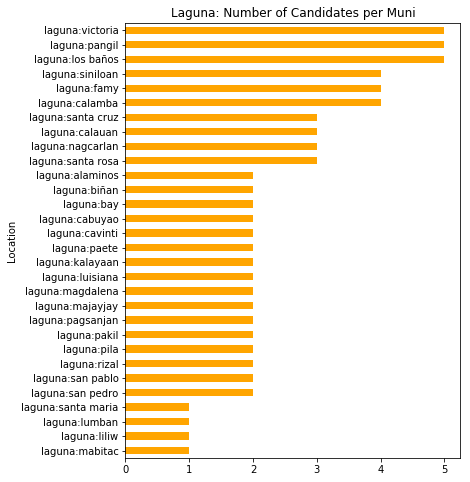

In [26]:
# Provinces: Cavite, Laguna, Batangas, Rizal, Quezon
prv_4a = 'Laguna'
display(cnt_plot(df_reg4a_cnt, prv_4a))

The left figure shows the percentage of support the winning mayoral candidate received from his city/municipality. With the exception of Calamba, the dark-colored areas coincide with the areas where the candidate ran unopposed.

The right figure demonstrates whether the winning candidate is affiliated with the administration or not. There are more areas in Laguna where the administration-backed candidate won the mayoral elections.

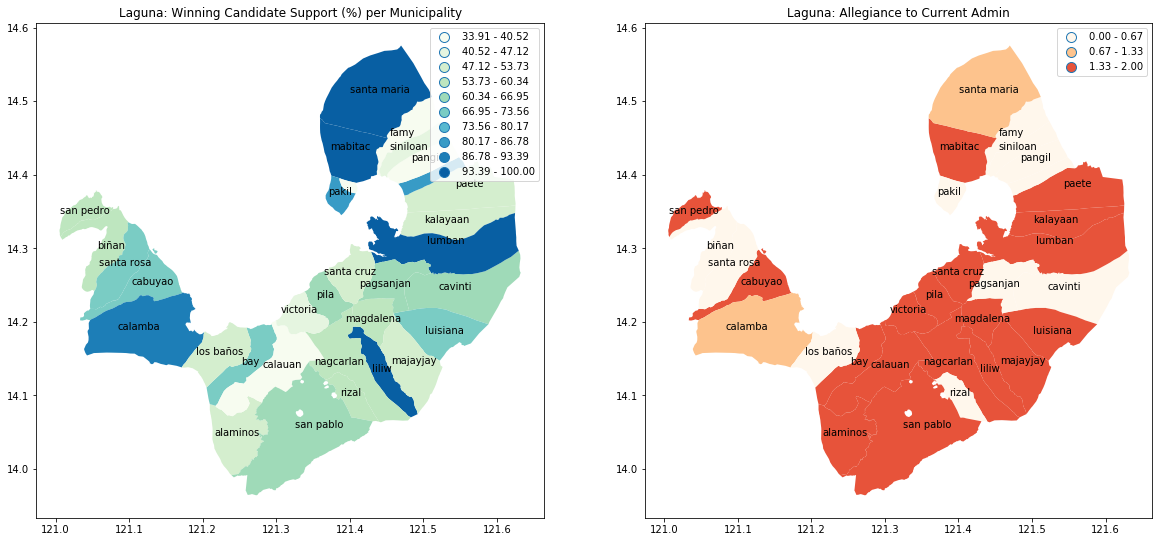

In [27]:
display(geomap(ph_muni, df_reg4a_topp, prv_4a, 10))

We again try to determine whether the candidates in a particular area are either affiliated with the administration or not. We map it out in the cell below.

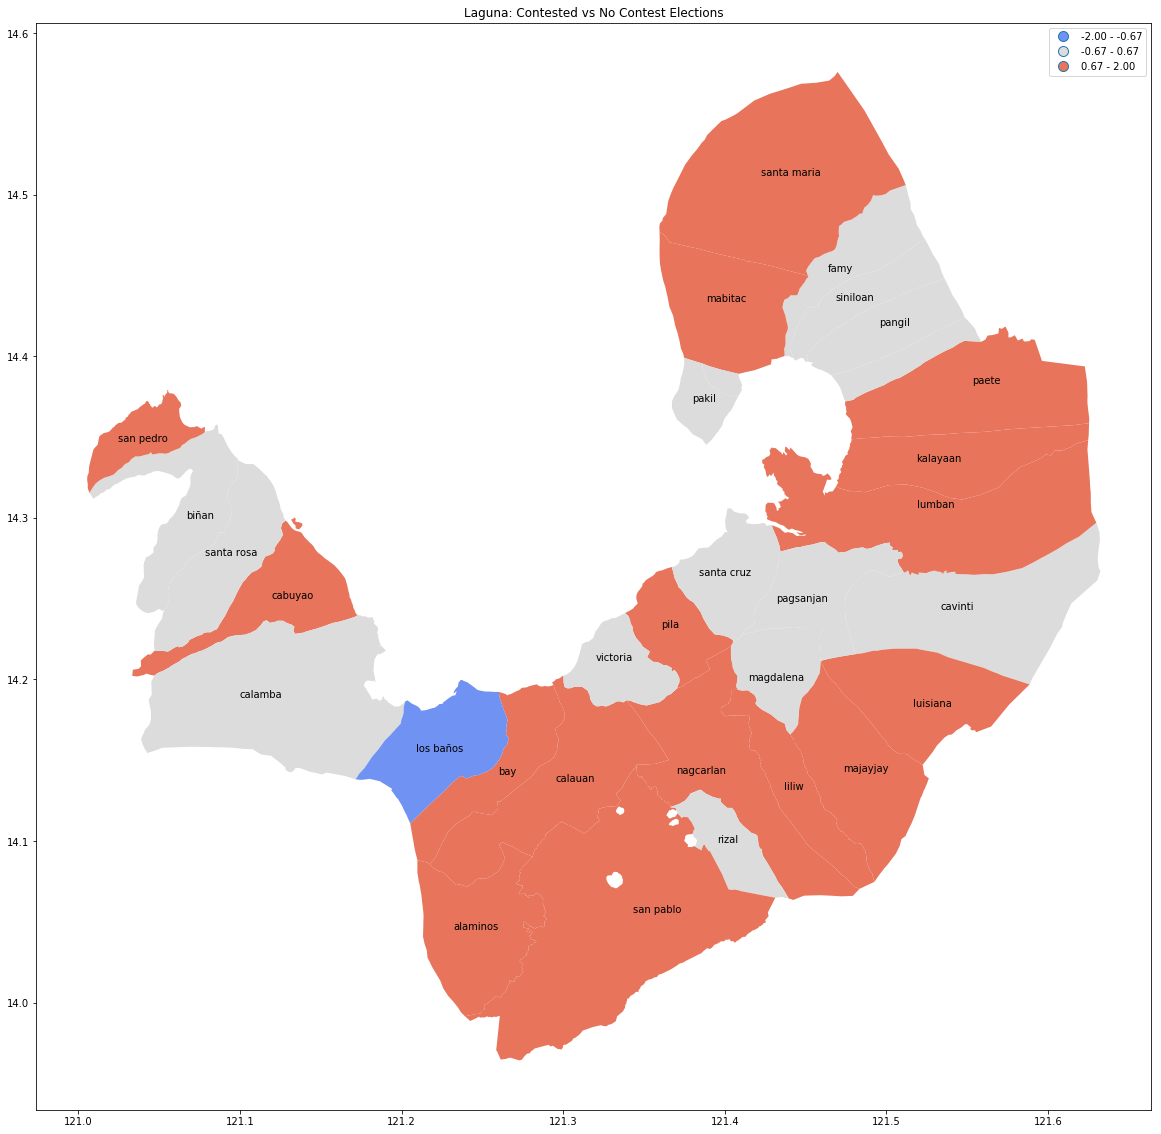

In [45]:
display(geomap_contest(ph_muni, df_pres, prv_4a))

It is interesting to note that a lot of areas are dominated by the administation-backed candidates, except Los Banos. All of the 5 candidates for the mayoral race in Los Banos are not affiliated with the administration party.

###### Nueva Ecija (Region 3)

We now look at the mayoral race in Nueva Ecija. There are 5 areas where the candidate ran unopposed: Gapan, Quezon, Rizal, San Antonio and Santa Rosa.

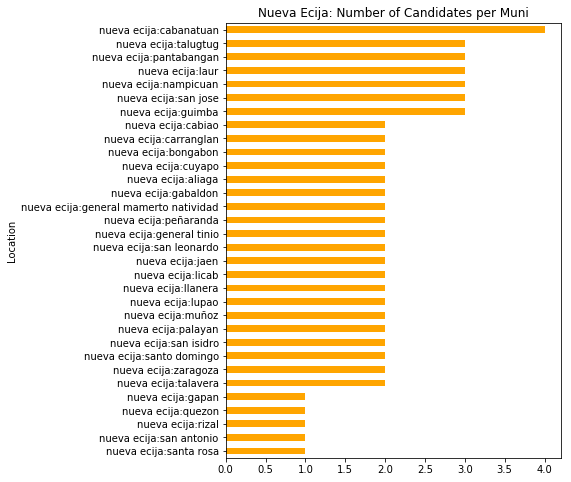

In [40]:
# Provinces: Aurora, Bataan, Bulacan, Nueva Ecija, Pampanga, Tarlac, Zambales
prv_3 = 'Nueva Ecija'
display(cnt_plot(df_reg3_cnt, prv_3))

The left figure shows the percentage of support the winning mayoral candidate received from his city/municipality. The dark-colored areas coincide with the areas where the candidate ran unopposed. We notice that for Nueva Ecija, majority of the winning candidates got the support of the majority from his/her constituency.

The right figure demonstrates whether the winning candidate is affiliated with the administration or not. It is interesting to note that only 4 areas had winning candidates that are backed by the administration.

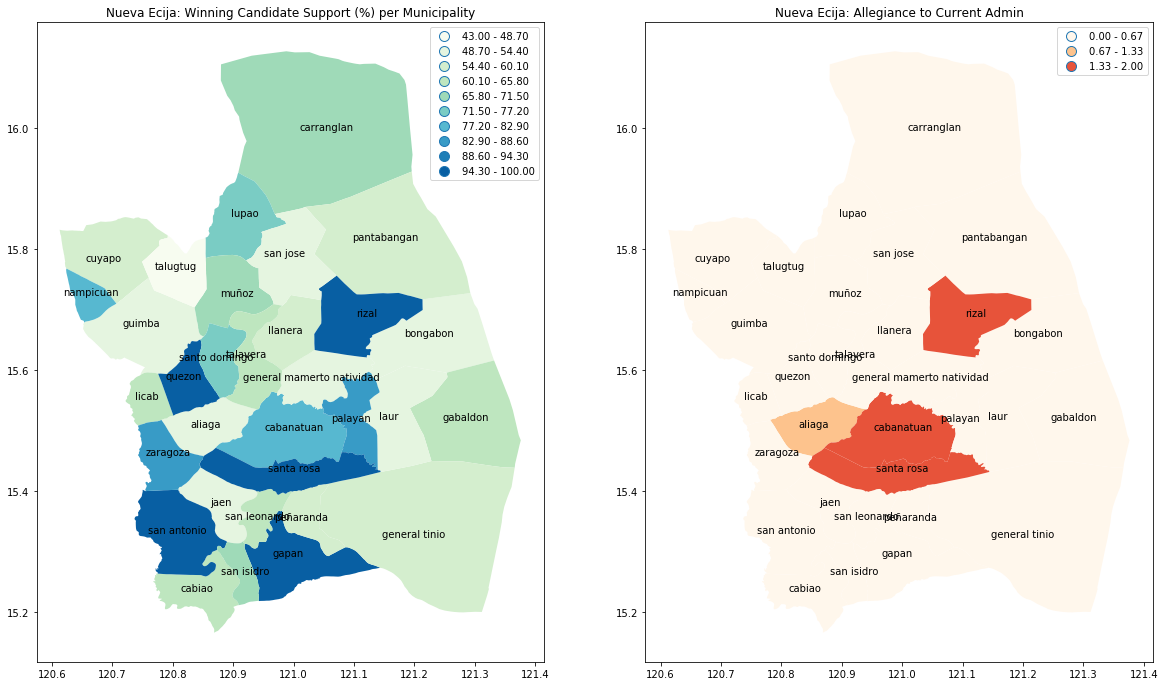

In [44]:
display(geomap(ph_muni, df_reg3_topp, prv_3, 10))

We again try to determine whether the candidates in a particular area are either affiliated with the administration or not. We map it out in the cell below.

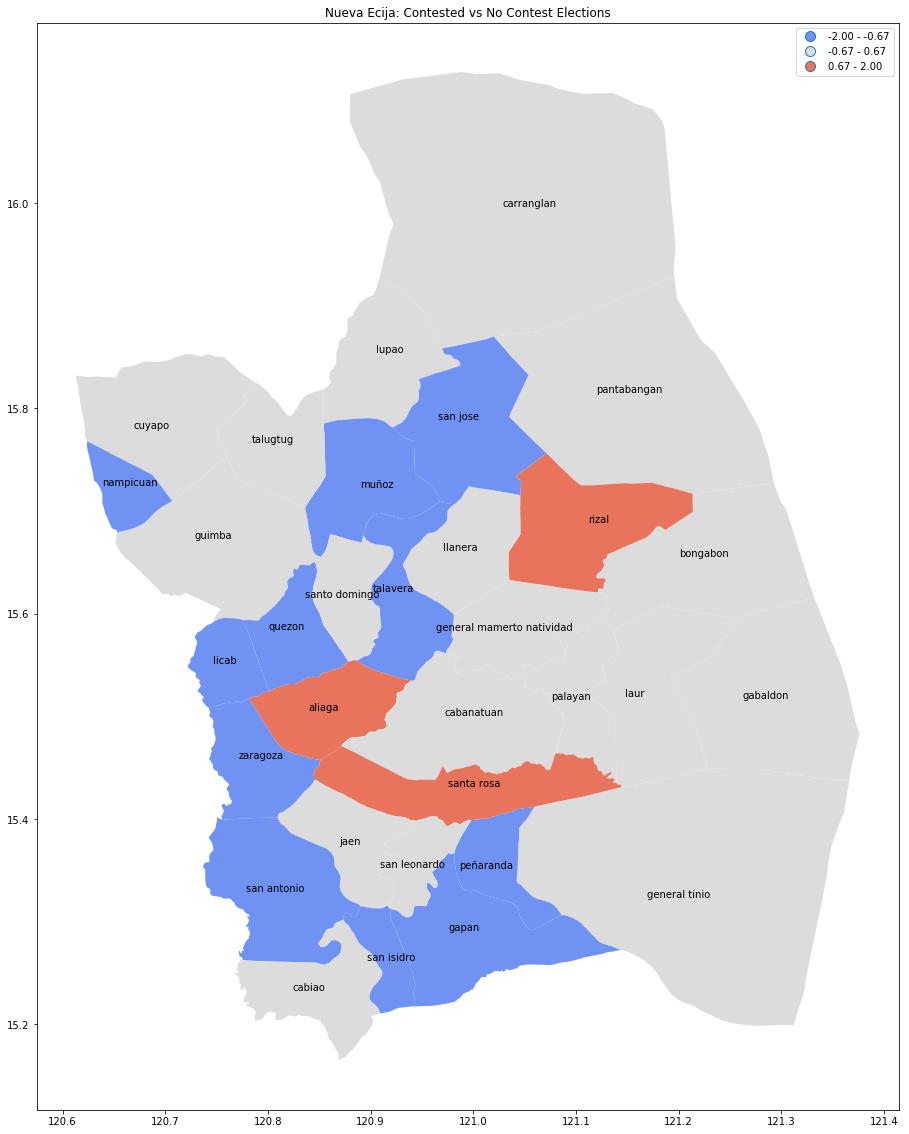

In [46]:
display(geomap_contest(ph_muni, df_pres, prv_3))

Note that the administration-backed candidates are uncontested in only 3 areas: Aliaga, Santa Rosa and Rizal. Candidates that are not affiliated with the administration ran uncontested in a lot of areas.

### Municipalities with no competition

For the three regions considered (NCR, Region III and Region IV-A), we determined the areas where the winning candidate ran uncontested. The results are displayed in the cell below.

In [48]:
df_tcnt = df_sum_c.groupby(['Location']).count()
df_tcnt = df_tcnt[df_tcnt['Candidate']==1]

df_unc = df_sum_c.set_index(['Location'])
df_unc = df_unc.loc[df_tcnt.index]

display(df_unc)

,Party,Candidate,Votes,Total Voters,Percentage,Province
Location,,,,,,
aurora:dingalan,PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN,"TAAY, SHIERWIN (PDPLBN)",9362,9362,100.0,aurora
aurora:maria aurora,PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN,"GENETA, AMADO (PDPLBN)",15757,15757,100.0,aurora
bataan:abucay,PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN,"SANTIAGO, PAMBATO (PDPLBN)",14629,14629,100.0,bataan
bataan:balanga,PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN,"GARCIA, FRANCIS (PDPLBN)",48194,48194,100.0,bataan
bataan:orani,NACIONALISTA PARTY,"PASCUAL, BONDJONG (NP)",23709,23709,100.0,bataan
bataan:orion,PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN,"RAYMUNDO, TONY-PEP (PDPLBN)",23543,23543,100.0,bataan
batangas:batangas,NACIONALISTA PARTY,"DIMACUHA, BEVERLEY (NP)",135547,135547,100.0,batangas
batangas:rosario,PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN,"ALVAREZ, MANNY (PDPLBN)",49250,49250,100.0,batangas
batangas:talisay,LGBTQ PARTY,"NATANAUAN, GERRY (IND)",14947,14947,100.0,batangas


### Why your vote matters

From the three chosen regions, we selected the municipalities with only 2 competing candidates. We extracted the municipalities where the competition was close, meaning that the difference of the votes is less than 300. Results are displayed in the cell below.

`df_test` shows the slice of the summary dataframe where there's less than 300 vote difference between the two running candidates.

In [73]:
df_tcnt = df_sum_c.groupby(['Location']).count()
df_tcnt = df_tcnt[df_tcnt['Candidate']==2]

df_cont = df_sum_c.set_index(['Location'])
df_cont = df_cont.loc[df_tcnt.index]

df_cont = df_cont.reset_index()

# Get difference between candidates
df_diff = df_cont.reset_index().groupby(['Location'])['Votes',
                                                      'Percentage'].diff()

dftest = df_cont.join(df_diff, rsuffix='_diff')
dftest = dftest.set_index('Location')
dftest = dftest.sort_values('Votes_diff')
dftest = dftest[abs(dftest['Votes_diff'])<=300]
dftest = dftest.sort_values('Percentage', ascending=False) # sort by perc col
display(dftest)

,Party,Candidate,Votes,Total Voters,Percentage,Province,Votes_diff,Percentage_diff
Location,,,,,,,,
quezon:general nakar,NACIONALISTA PARTY,"RUZOL, ELISEO (NP)",8323,16368,50.849218,quezon,278.0,1.698436
tarlac:anao,PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN,"NARAL, RAFAEL (PDPLBN)",3288,6499,50.592399,tarlac,77.0,1.184798
bataan:samal,PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN,"MACALINAO, AIDA (PDPLBN)",10571,21005,50.326113,bataan,137.0,0.652226
laguna:paete,PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN,"BAGABALDO, MUTUK (PDPLBN)",6357,12635,50.312624,laguna,79.0,0.625247
pampanga:san simon,PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN,"PUNSALAN, JP (PDPLBN)",15324,30504,50.236035,pampanga,144.0,0.472069
batangas:ibaan,PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN,"SALVAME, JOY (PDPLBN)",16285,32420,50.231339,batangas,150.0,0.462677
quezon:unisan,PARTIDO DEMOKRATIKO PILIPINO LAKAS NG BAYAN,"ADULTA, FERDINAND (PDPLBN)",6078,12120,50.148515,quezon,36.0,0.297030
nueva ecija:aliaga,NATIONALIST PEOPLE'S COALITION,"VARGAS, GELO (NPC)",18143,36192,50.129863,nueva ecija,94.0,0.259726
pampanga:magalang,PARTIDO FEDERAL NG PILIPINAS,"PECSON, ROMY (PFP)",27166,54305,50.024860,pampanga,27.0,0.049719


We are only going to look at the results in Magalang, Pampanga. The winning candidate won by only 27 votes. We now look at the 2015 census data from Magalang, Pampanga.

In [65]:
# SAZ Total Voters
dftest = dftest.sort_values('Votes_diff', ascending=False) # sort votes_diff
pop_voted = dftest.loc['pampanga:magalang']['Total Voters']
print(f'Magalang Pampanga Voters (2019): {pop_voted}')

Magalang Pampanga Voters (2019): 54305


`df_show` slices the dataframe obtained from the census data of interest to zoom in on the city of interest.

We can therefore compute for the expected voting population by computing for the population in the age range of 15 and up.

In [72]:
file = '/mnt/data/public/census/Pampanga_Statistical Tables.xls'

df_saz = pd.read_excel(file,
                       header=3).dropna(how=
                                        'any').drop(2).reset_index(drop=True)
saz_pop = int(df_saz.iloc[9].to_list()[-1])

# Magalang, Pampanga Population
print(f'Magalang Pampanga Population (2015): {saz_pop}')

df_show = pd.read_excel(file, sheet_name='T4').drop(np.arange(263))
df_show.columns = ['Age Group By City', 'Both Sexes', 'Male', 'Female']
display(df_show.head(20))
df_t2 = pd.read_excel(file, sheet_name='T4').drop(np.arange(269))

est_vpop = sum(df_t2["Unnamed: 1"].to_list()[0:14])

# Magalang, Pampanga Estimated Voting Population
print(f'Voting Population Estimate by 2019: {est_vpop}')
print(f'\nNumber of voters that did not vote: {est_vpop - pop_voted}')
print(f'% of voters that voted: {round(100*pop_voted/est_vpop,2)}')

Magalang Pampanga Population (2015): 113147


,Age Group By City,Both Sexes,Male,Female
263,MAGALANG,NaN,NaN,NaN
264,All Ages,113147,57783,55364
265,Under 1,2047,1047,1000
266,1 - 4,8743,4532,4211
267,5 - 9,11580,5977,5603
268,10 - 14,11959,6179,5780
269,15 - 19,11811,6115,5696
270,20 - 24,10595,5583,5012
271,25 - 29,9139,4674,4465
272,30 - 34,8342,4185,4157


Voting Population Estimate by 2019: 78818

Number of voters that did not vote: 24513
% of voters that voted: 68.9


We estimated the voting population from the 2015 census data under the assumption that the ones who are at least 14 years old in 2015 are eligible to vote by this year. We also assume that the death rate is negligible. We need an updated census data to get the actual voting population of Magalang, Pampanga.

In any case, it is estimated that only 69% of the voting population participated in the elections. This could have spelled the difference in the results for the mayoral race.

### Summary

The key takeaway from the visualization is the distribution of the winning candidates that are backed by the administration. NCR is practically divided between the administration-backed candidates and the non-administration-backed candidates. The winning candidates from Laguna are mostly backed by the administration. In contrast, only 4 winning candidates in Nueva Ecija are backed by the administration.

To get a clearer picture of the trend, all provinces of the region must be considered. At least, for Region III and Region IV-A, the chosen province can be edited in the cells.

It would also be interesting to look at the results of the senatorial elections in NCR, Laguna and Nueva Ecija. Maybe we can determine from that data whether the choice of the local candidate influenced their choice in the senatorial elections.

It would also be helpful if the 2019 census data is available, so that we can assess the voter participation in the elections.